In [1]:
import kwant
import matplotlib.pyplot as plt
import numpy as np
from ccode.finite_system import finite_system
import scipy.sparse.linalg as sla
import ccode.tools as tl
from ccode.boundstate import find_boundstates, extract_boundstates
import time
import dask.bag as db
from dask_quantumtinkerer import Cluster, cluster_options
import itertools as it
from scipy.signal import find_peaks
import pickle
import gc
%matplotlib inline
plt.rcParams.update({"font.size": 15})

/opt/conda/lib/python3.9/site-packages/dask_gateway/client.py:21: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import LoopRunner, format_bytes


In [2]:
np.warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [3]:
params = tl.junction_parameters(m_nw=np.array([-2, 0, -2]), m_qd=-2, bx=0.011)
a = params['a']

### Cluster configuration

In [4]:
options = cluster_options()
options.worker_cores = 1  # you should always leave this to 1 (I think)
options.worker_memory = 2  # Need to atdjust this to meet your needs
options.extra_path = "/home/jtorresluna/work/trijunction_design/"  # Make sure to do this if you import any local modules!

In [5]:
cluster = Cluster(options)

In [6]:
cluster

In [9]:
print(
    "http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"
    + cluster.dashboard_link[17:]
)

http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/6c310884d5f34dfdb433d28bb53a7195/status


In [10]:
client = cluster.get_client()

In [57]:
cluster.close()

KeyboardInterrupt: 

# Rectangular geometry

## Set up

In [17]:
geometry = {
    "l": 70*a,
    "w": 7*a,
    "a": a,
    "side": 'up',
    "shape": 'rectangle',
    "L": 20*a
}

In [23]:
n_geometries = 4
tj_widths = np.linspace(20*a, 50*a, n_geometries)

In [24]:
tjs = []
for width in tj_widths:
    geometry.update(W=width)
    geometry.update(center=7*a)
    trijunction, f_params, _ = finite_system(**geometry)
    trijunction = trijunction.finalized()
    tjs.append([trijunction, f_params])

/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecati

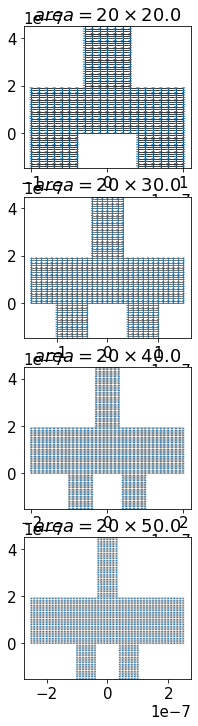

In [25]:
fig, ax = plt.subplots(nrows=n_geometries, ncols=1, figsize=(3, 3*n_geometries))
i = 0
for axes in ax.flatten():
    kwant.plot(tjs[i][0], ax=axes)
    axes.set_ylim(-1.5e-7, 4.5e-7)
    axes.set_title(r'$area=20\times$'+str(np.round(tj_widths[i]/a, 3)))
    #axes.set_xlim(-5e-7, 5e-7)
    #axes.set_title(r'$\theta/\pi$='+str(np.round(angles[i], 3)))
    i += 1

## Calculation: single band

In [15]:
# index is used to choose the sub band of a wire of width 7*a
index = 0
params = tl.finite_coupling_parameters(index=index)
title = 'rectangular trijunction size depencedence '+str(index)+'th band'

In [16]:
mus_qd = np.linspace(-0.011, 0.01, 50)
key = 'mu_qd'
n = 6
eigen = tl.solver(n=n, key=key)

In [17]:
def wrap(args):
    return eigen(*args)

In [18]:
args = list(it.product(tjs, mus_qd, params))
args_db = db.from_sequence(args, npartitions=20)

In [19]:
result = args_db.map(wrap).compute()

In [20]:
average_data = []
full_data = []
data_geometries = tl.separate_data_geometries(data=result, n_geometries=n_geometries)
for geometry in data_geometries:
    averages = tl.average_energy_levels(mus=mus_qd, result=geometry)
    average_data.append(averages)
    couplings, _, _ = tl.coupling_data(data=geometry, n=n)
    full_data.append(couplings)

In [21]:
xlims = (-2.7e-7, 2.7e-7)
ylims = (-0.5e-7, 2.5e-7)

subtitles = []
for i in range(n_geometries):
    subtitles.append(r'$area=20\times$'+str(np.round(tj_widths[i]/a, 3)))

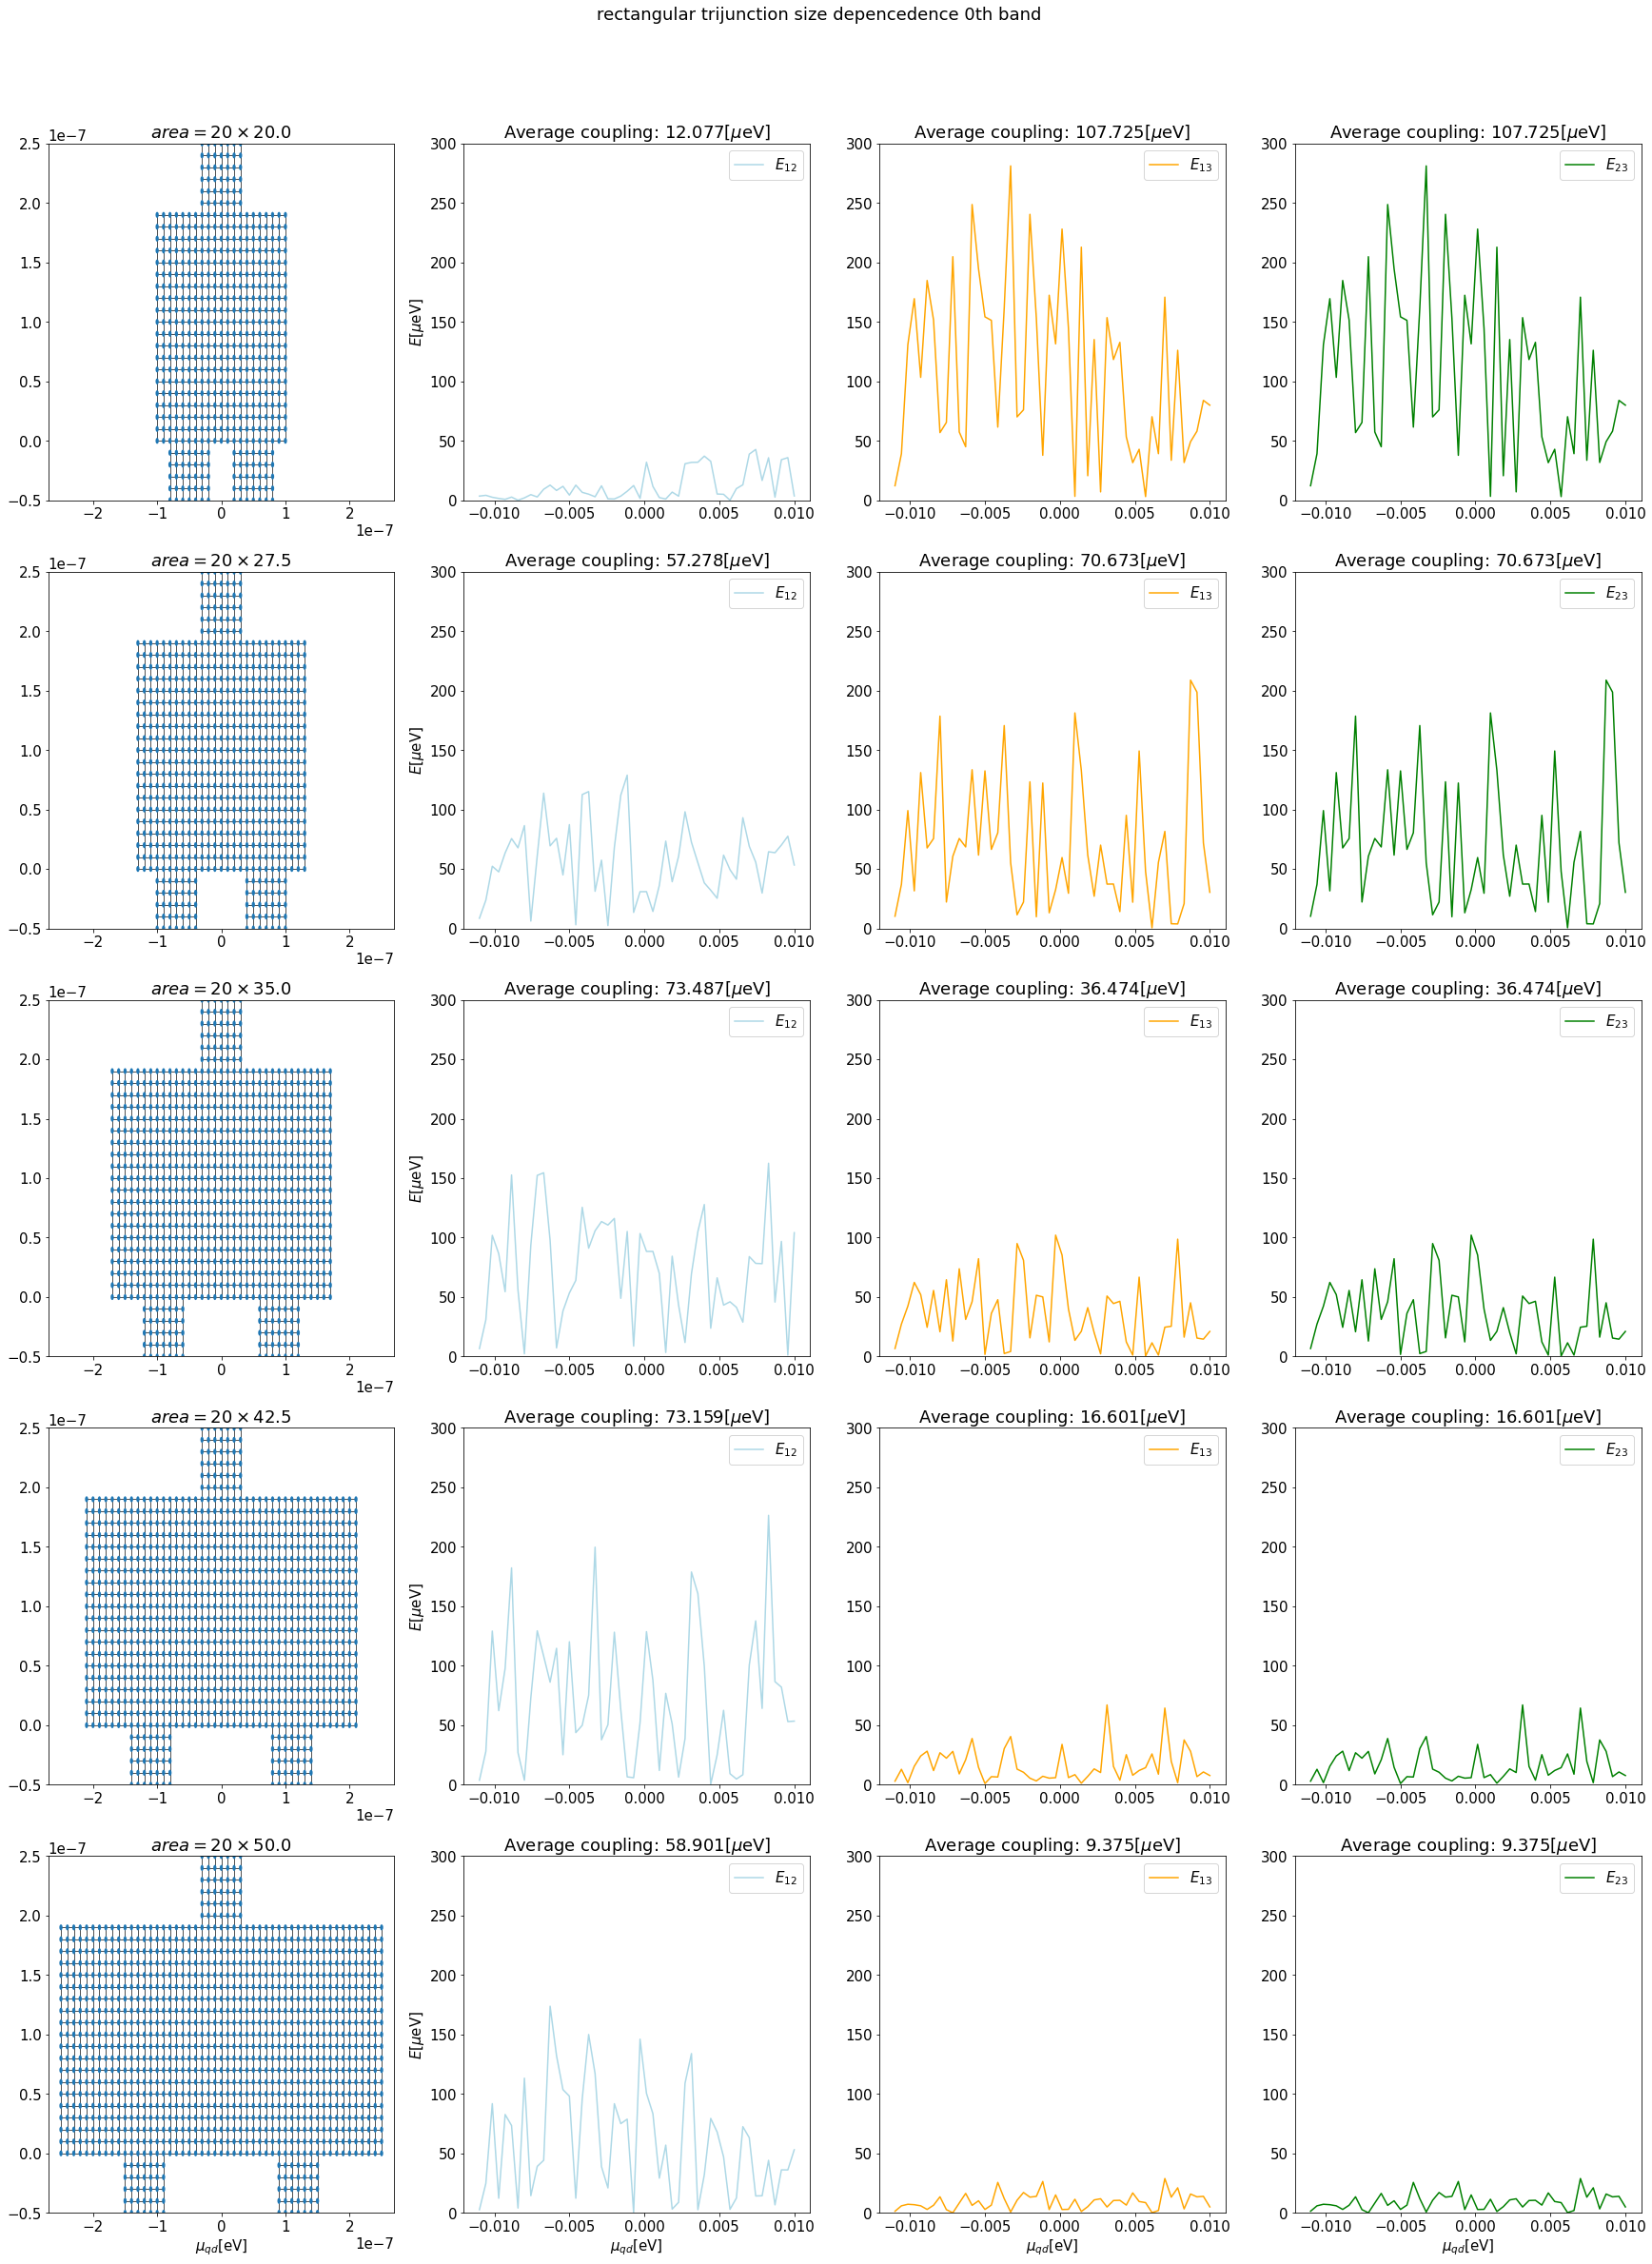

In [22]:
tl.plot_couplings(tjs=tjs,
                  mus=mus_qd,
                  full_data=full_data,
                  title=title,
                  n_geometries=n_geometries,
                  subtitles=subtitles,
                  xlims=xlims,
                  ylims=ylims)

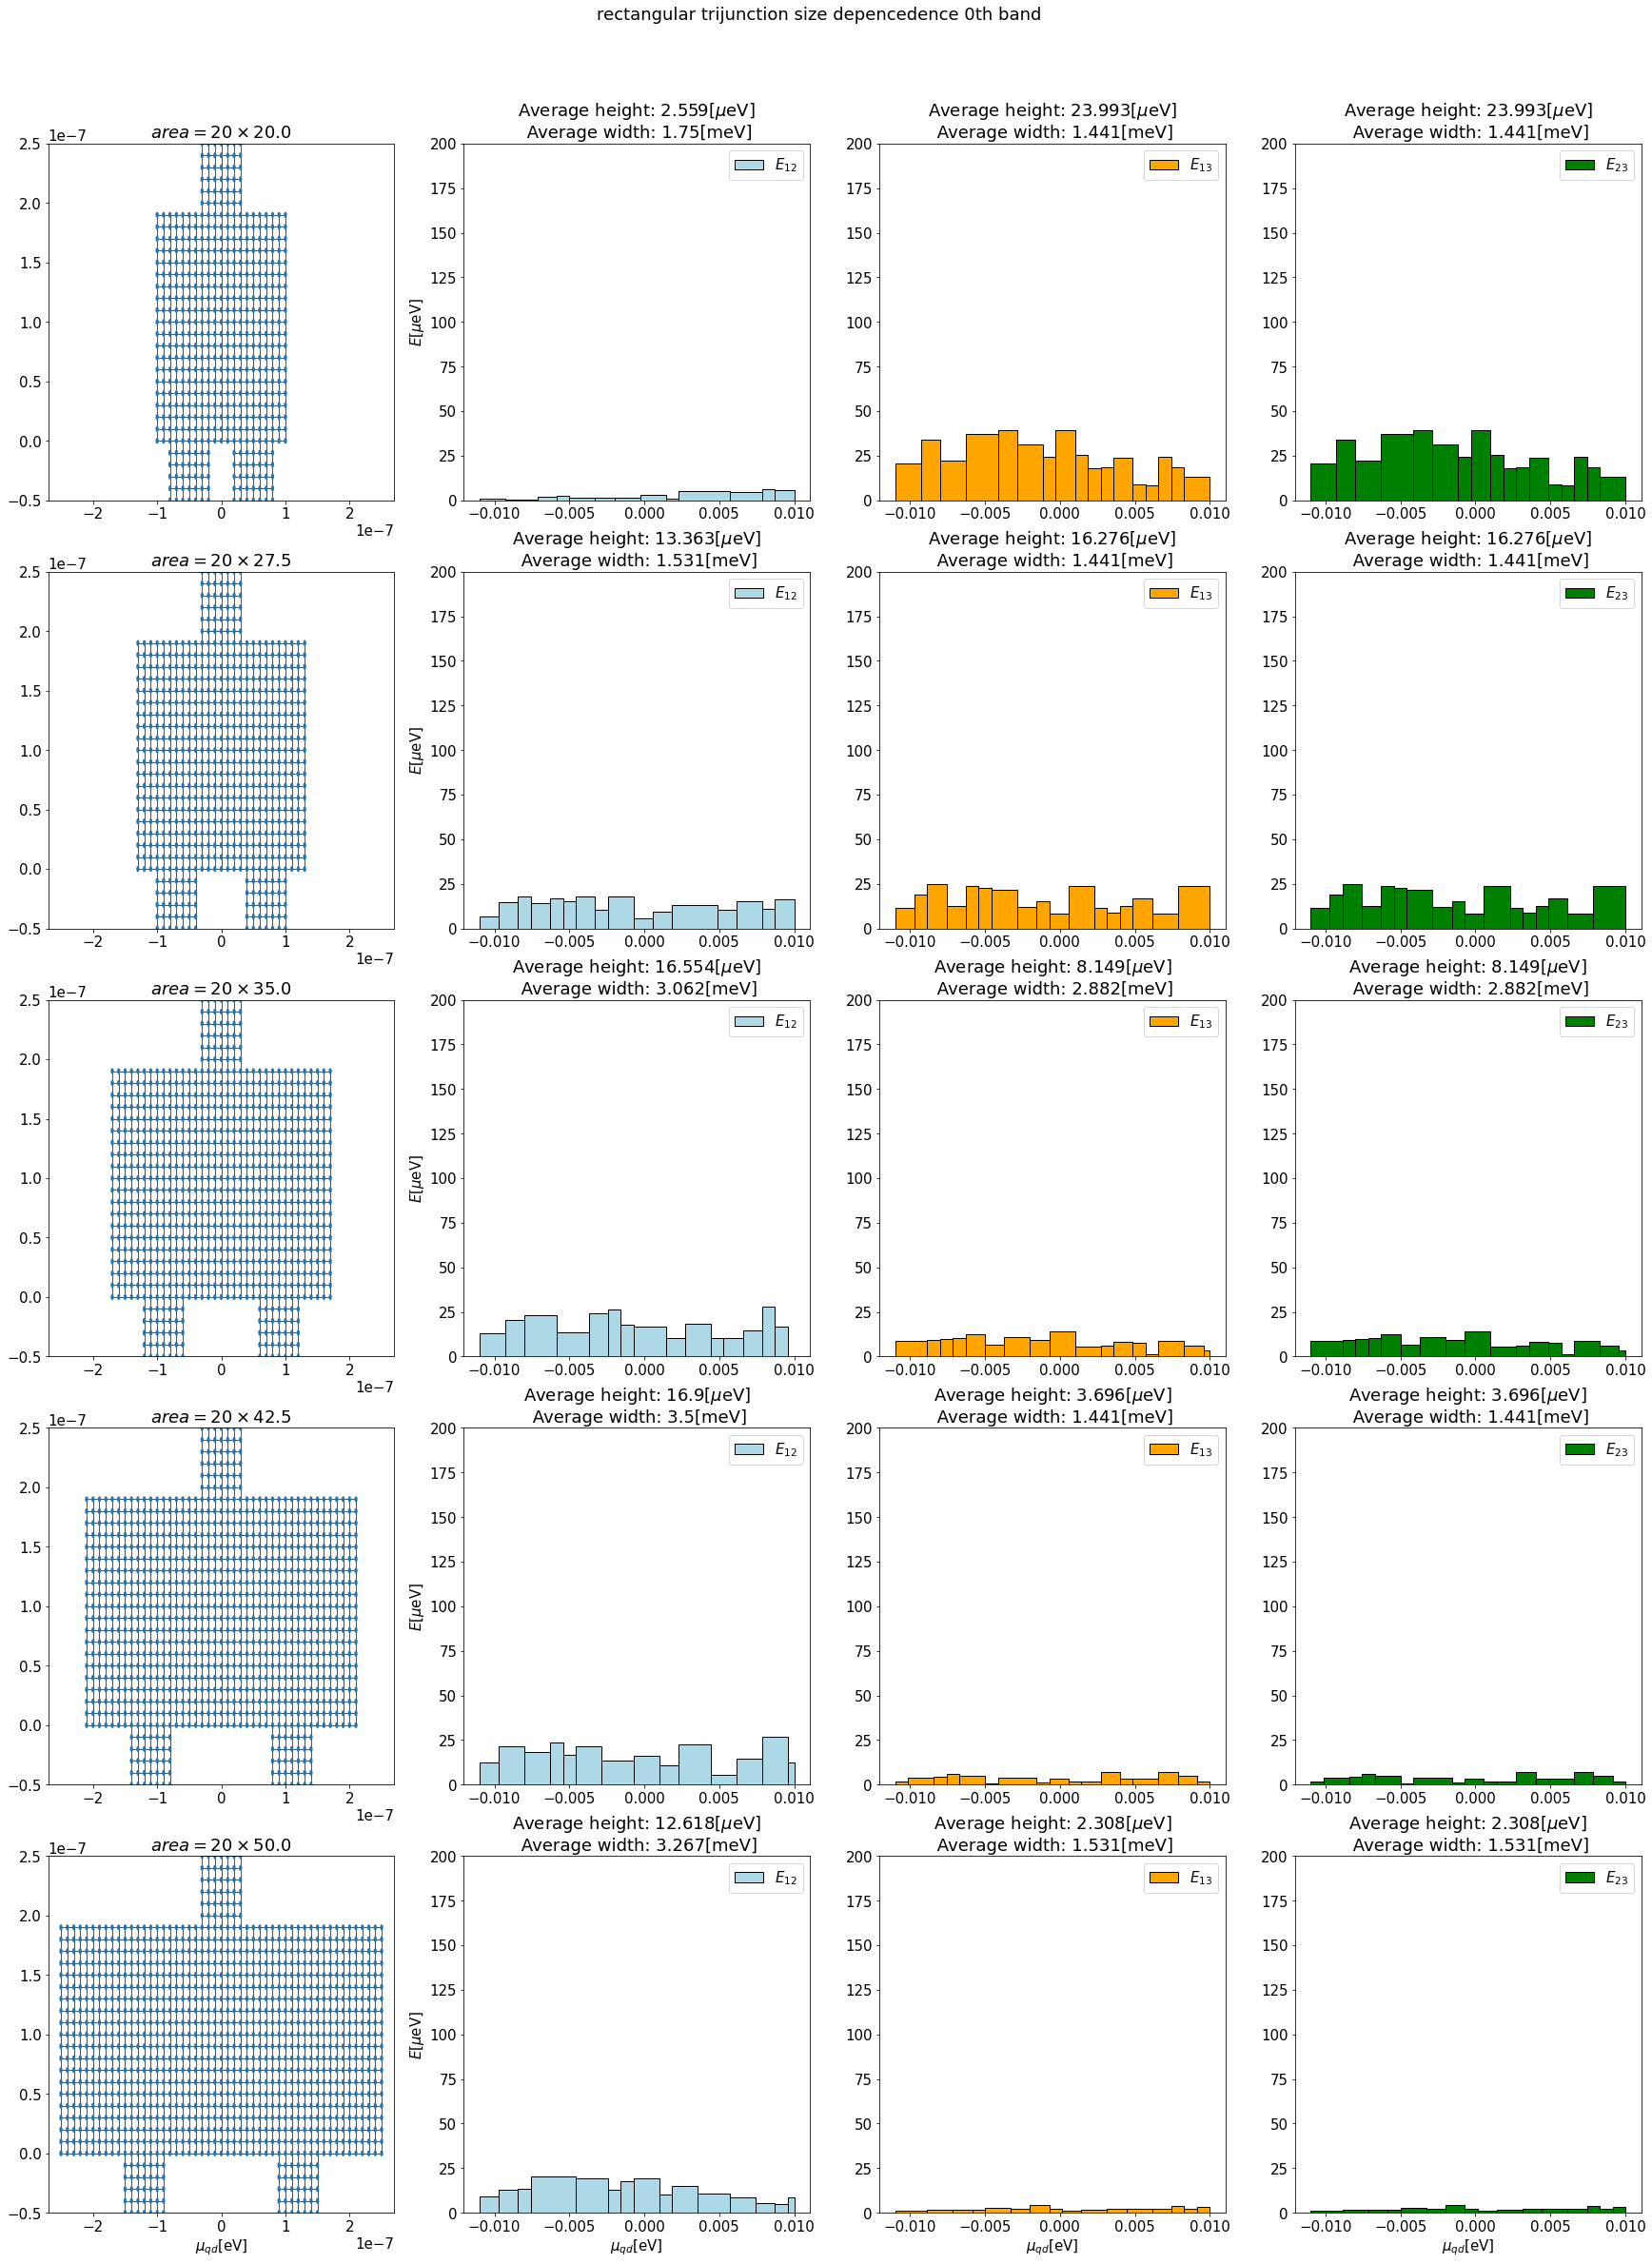

In [23]:
tl.plot_average_couplings(tjs=tjs,
                          average_data=average_data,
                          title=title,
                          n_geometries=n_geometries,
                          subtitles=subtitles,
                          xlims=xlims,
                          ylims=ylims)

## Calculation: all bands

In [26]:
mus_qd = np.linspace(-0.011, 0.01, 200)
key = 'mu_qd'
n = 6
eigen = tl.solver(n=n, key=key)

In [27]:
def wrap(args):
    return eigen(*args)

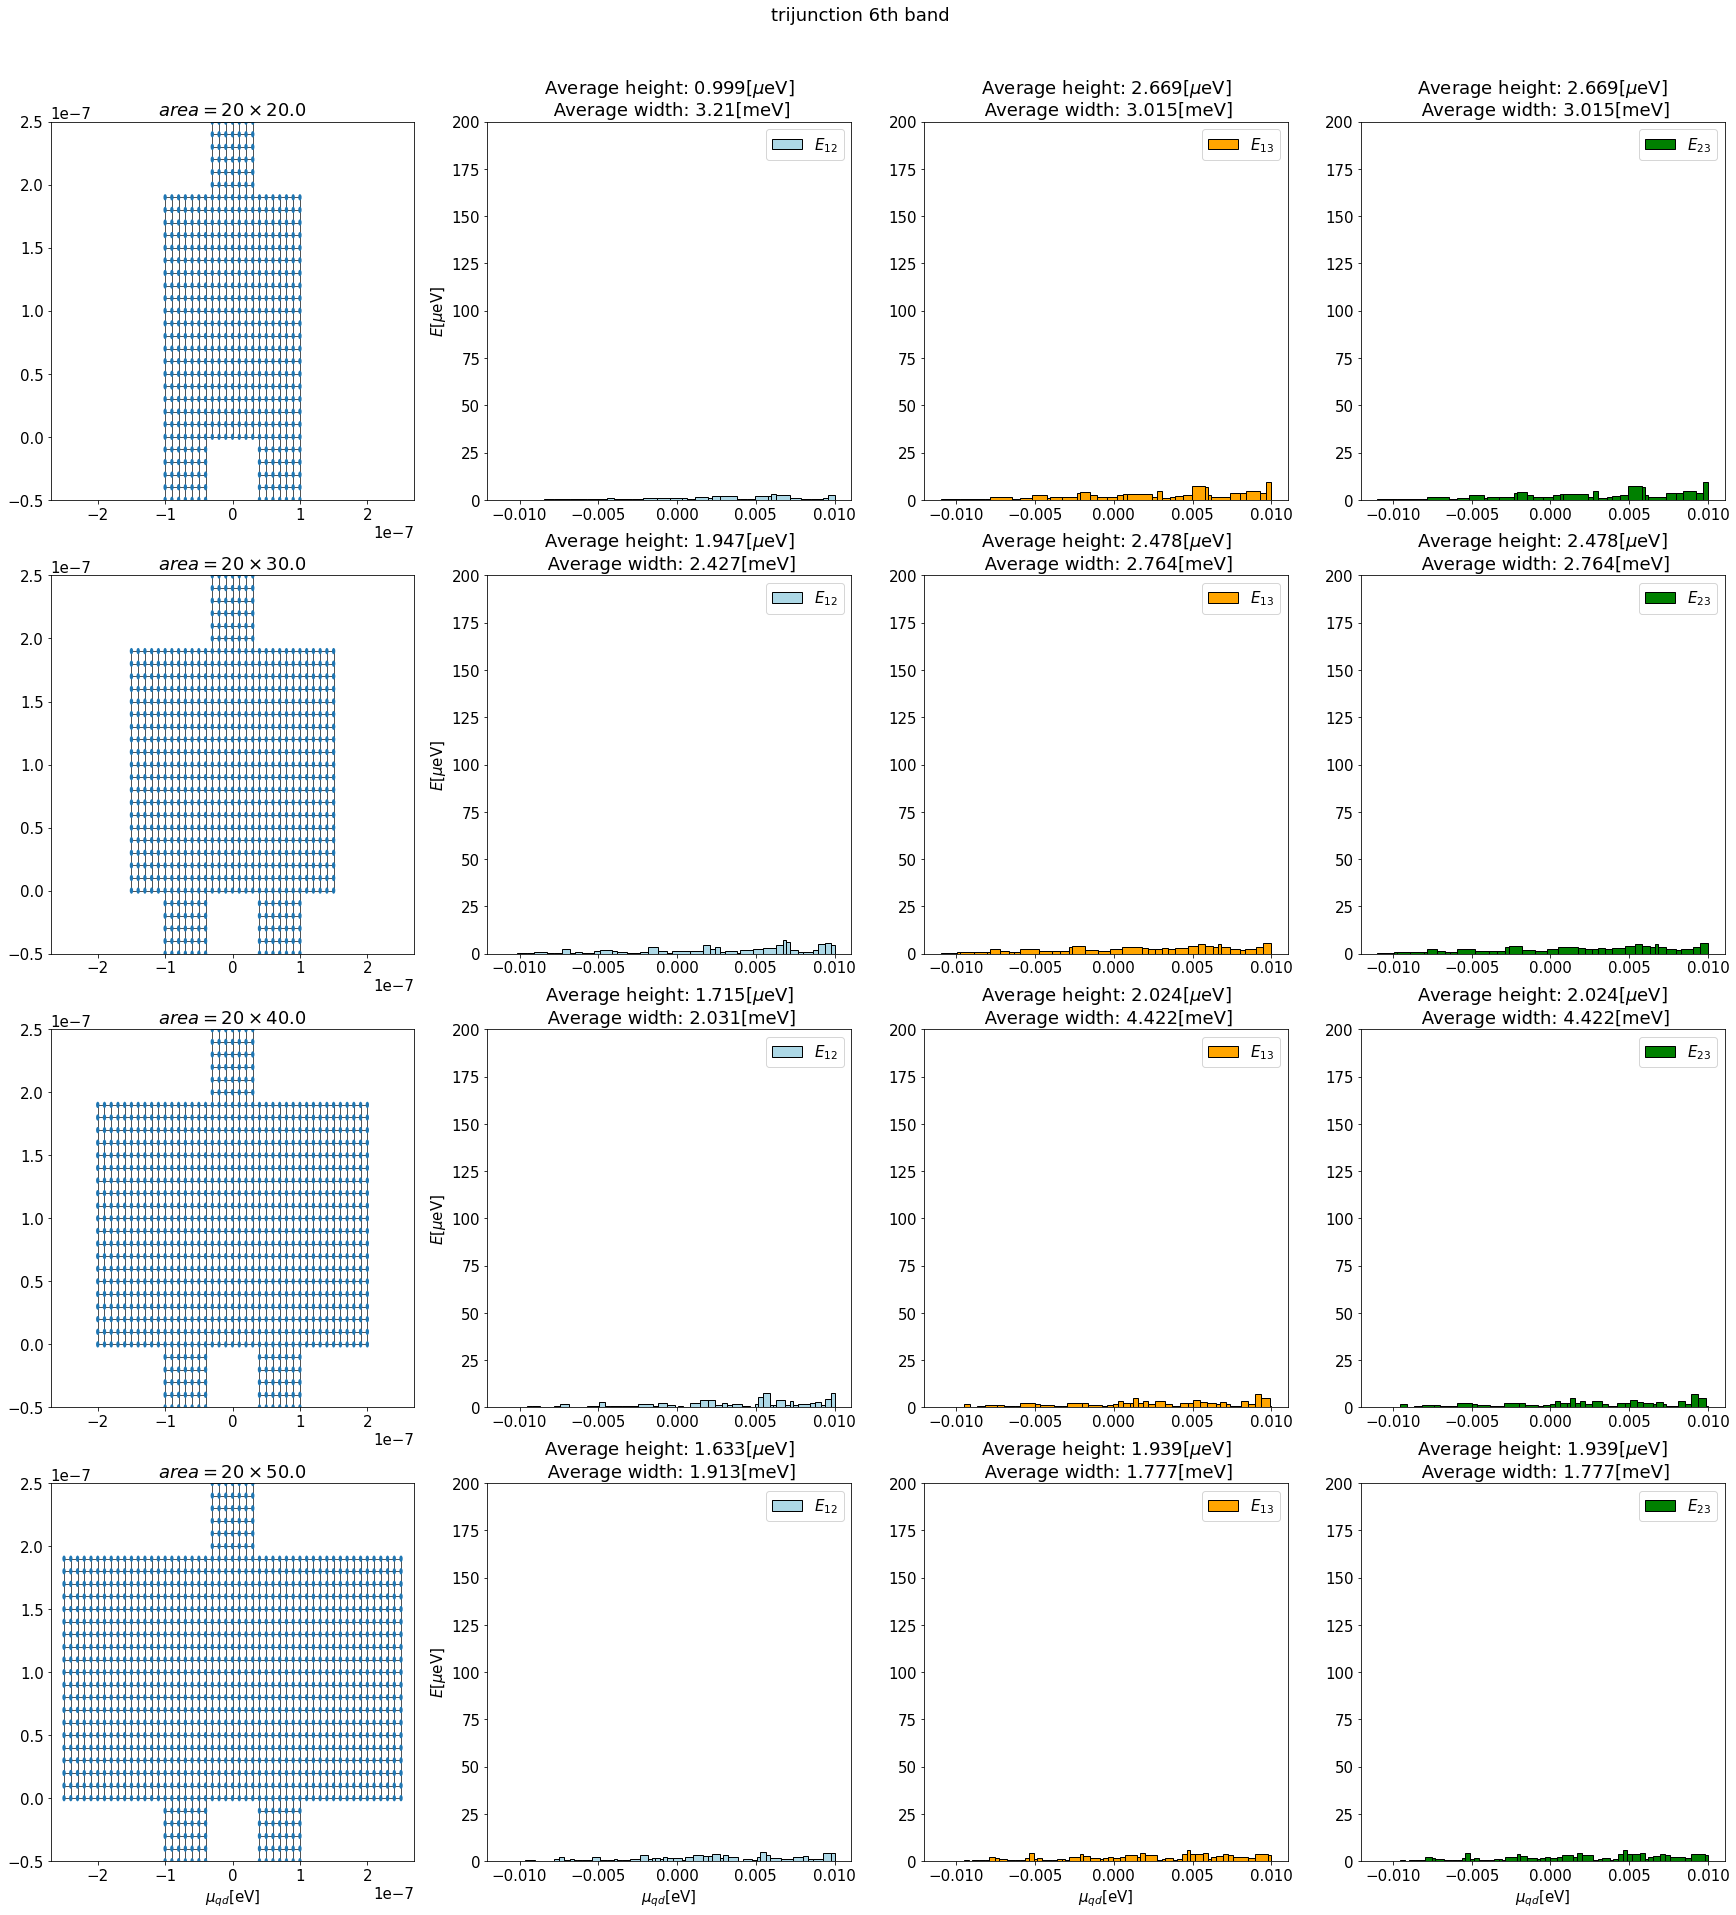

In [28]:
xlims = (-2.7e-7, 2.7e-7)
ylims = (-0.5e-7, 2.5e-7)

subtitles = []
for i in range(n_geometries):
    subtitles.append(r'$area=20\times$'+str(np.round(tj_widths[i]/a, 3)))

for index in range(7):

    params = tl.finite_coupling_parameters(index=index)
    title = 'trijunction '+str(index)+'th band'
    
    args = list(it.product(tjs, mus_qd, params))
    args_db = db.from_sequence(args, npartitions=20)
    result = args_db.map(wrap).compute()
    
    average_data = []
    full_data = []
    data_geometries = tl.separate_data_geometries(data=result, n_geometries=n_geometries)

    for geometry in data_geometries:
        average_data.append(tl.average_energy_levels(mus=mus_qd, result=geometry))
        couplings, _, _ = tl.coupling_data(data=geometry, n=n)
        full_data.append(couplings)

    with open('../data/average_'+title.replace(' ', '_')+'.pickle', 'wb') as file:
        pickle.dump(average_data, file)

    with open('../data/full_'+title.replace(' ', '_')+'.pickle', 'wb') as file:
        pickle.dump(full_data, file)

    tl.plot_couplings(tjs=tjs,
                      mus=mus_qd,
                      full_data=full_data,
                      title=title,
                      n_geometries=n_geometries,
                      subtitles=subtitles,
                      xlims=xlims,
                      ylims=ylims,
                      ylim=300)

    tl.plot_average_couplings(tjs=tjs,
                              average_data=average_data,
                              title=title,
                              n_geometries=n_geometries,
                              subtitles=subtitles,
                              xlims=xlims,
                              ylims=ylims,
                              ylim=200)

# Circular geometry

## Set up

In [29]:
geometry = {
    "l": 70*a,
    "w": 7*a,
    "a": a,
    "side": 'up',
    "shape": 'circle',
    "r": 12*a
}

In [33]:
n_geometries = 5
tj_rads = np.linspace(20*a, 30*a, n_geometries)

In [34]:
tjs = []
for R in tj_rads:
    geometry.update(R=R)
    geometry.update(center=width/4)
    trijunction, f_params, _ = finite_system(**geometry)
    trijunction = trijunction.finalized()
    tjs.append([trijunction, f_params])

/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecati

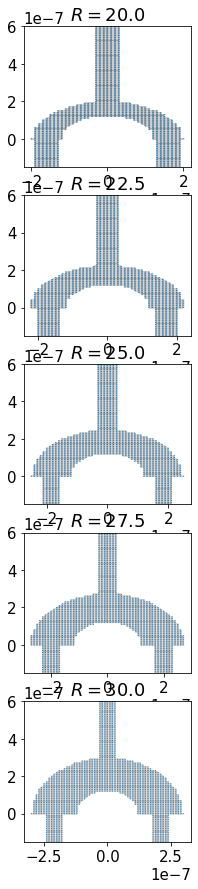

In [36]:
fig, ax = plt.subplots(nrows=n_geometries, ncols=1, figsize=(3, 3*n_geometries))
i = 0
for axes in ax.flatten():
    kwant.plot(tjs[i][0], ax=axes)
    axes.set_ylim(-1.5e-7, 6e-7)
    axes.set_title(r'$R=$'+str(np.round(tj_rads[i]/a, 3)))
    #axes.set_xlim(-5e-7, 5e-7)
    #axes.set_title(r'$\theta/\pi$='+str(np.round(angles[i], 3)))
    i += 1

## Calculation: single band

In [69]:
# index is used to choose the sub band of a wire of width 7*a
index = 0
params = tl.finite_coupling_parameters(index=index)
title = 'circular trijunction size depencedence '+str(index)+'th band'

In [70]:
mus_qd = np.linspace(-0.011, 0.01, 200)
key = 'mu_qd'
n = 6
eigen = tl.solver(n=n, key=key)

In [71]:
def wrap(args):
    return eigen(*args)

In [72]:
args = list(it.product(tjs, mus_qd, params))
args_db = db.from_sequence(args, npartitions=20)

In [73]:
result = args_db.map(wrap).compute()

In [74]:
average_data = []
full_data = []
data_geometries = tl.separate_data_geometries(data=result, n_geometries=n_geometries)
for geometry in data_geometries:
    averages = tl.average_energy_levels(mus=mus_qd, result=geometry)
    average_data.append(averages)
    couplings, _, _ = tl.coupling_data(data=geometry, n=n)
    full_data.append(couplings)

In [75]:
xlims = (-3e-7, 3e-7)
ylims = (-0.5e-7, 3e-7)

subtitles = []
for i in range(n_geometries):
    subtitles.append(r'$area=20\times$'+str(np.round(tj_widths[i]/a, 3)))

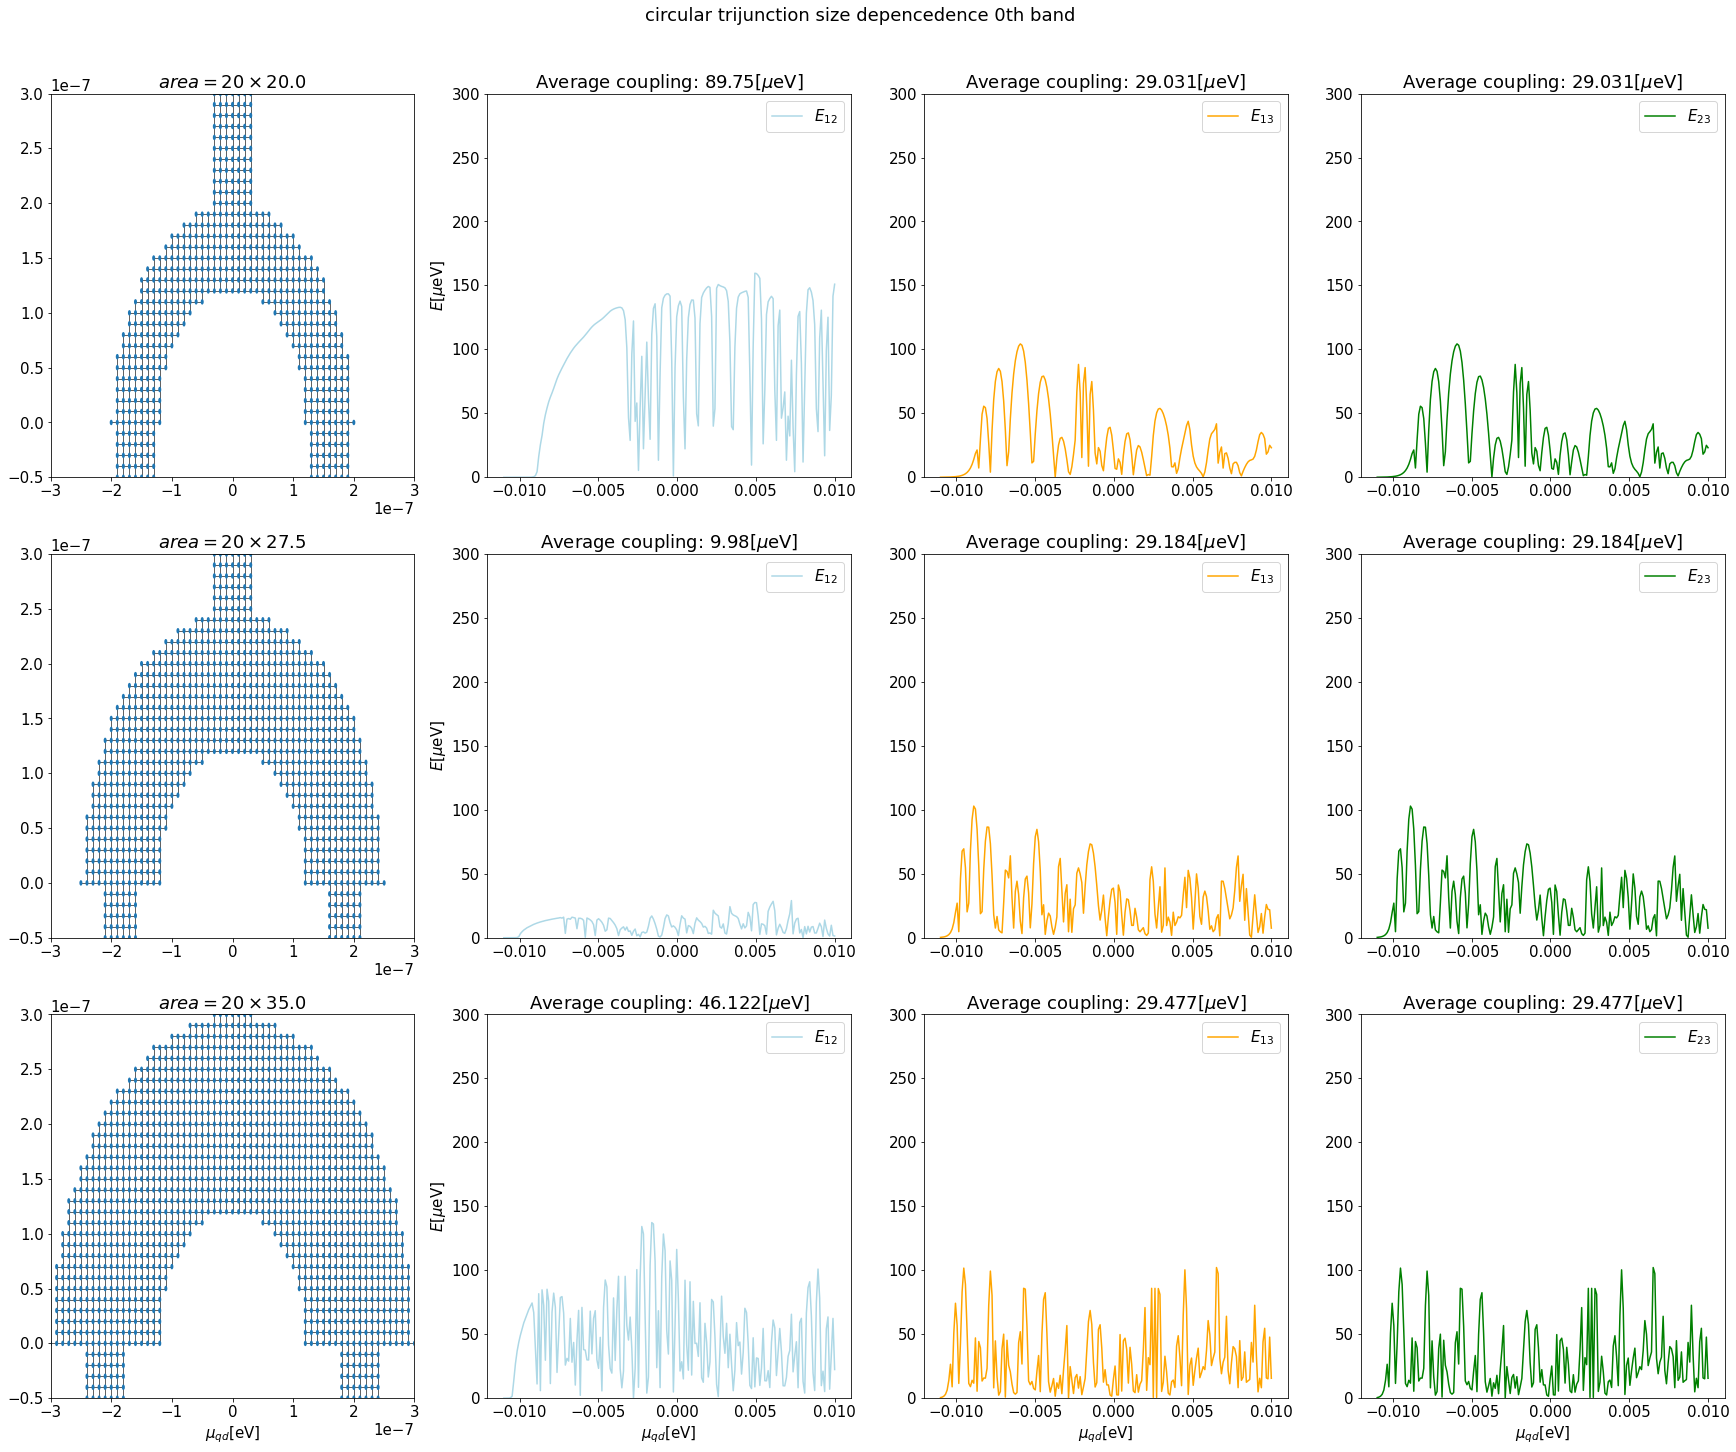

In [76]:
tl.plot_couplings(tjs=tjs,
                  mus=mus_qd,
                  full_data=full_data,
                  title=title,
                  n_geometries=n_geometries,
                  subtitles=subtitles,
                  xlims=xlims,
                  ylims=ylims)

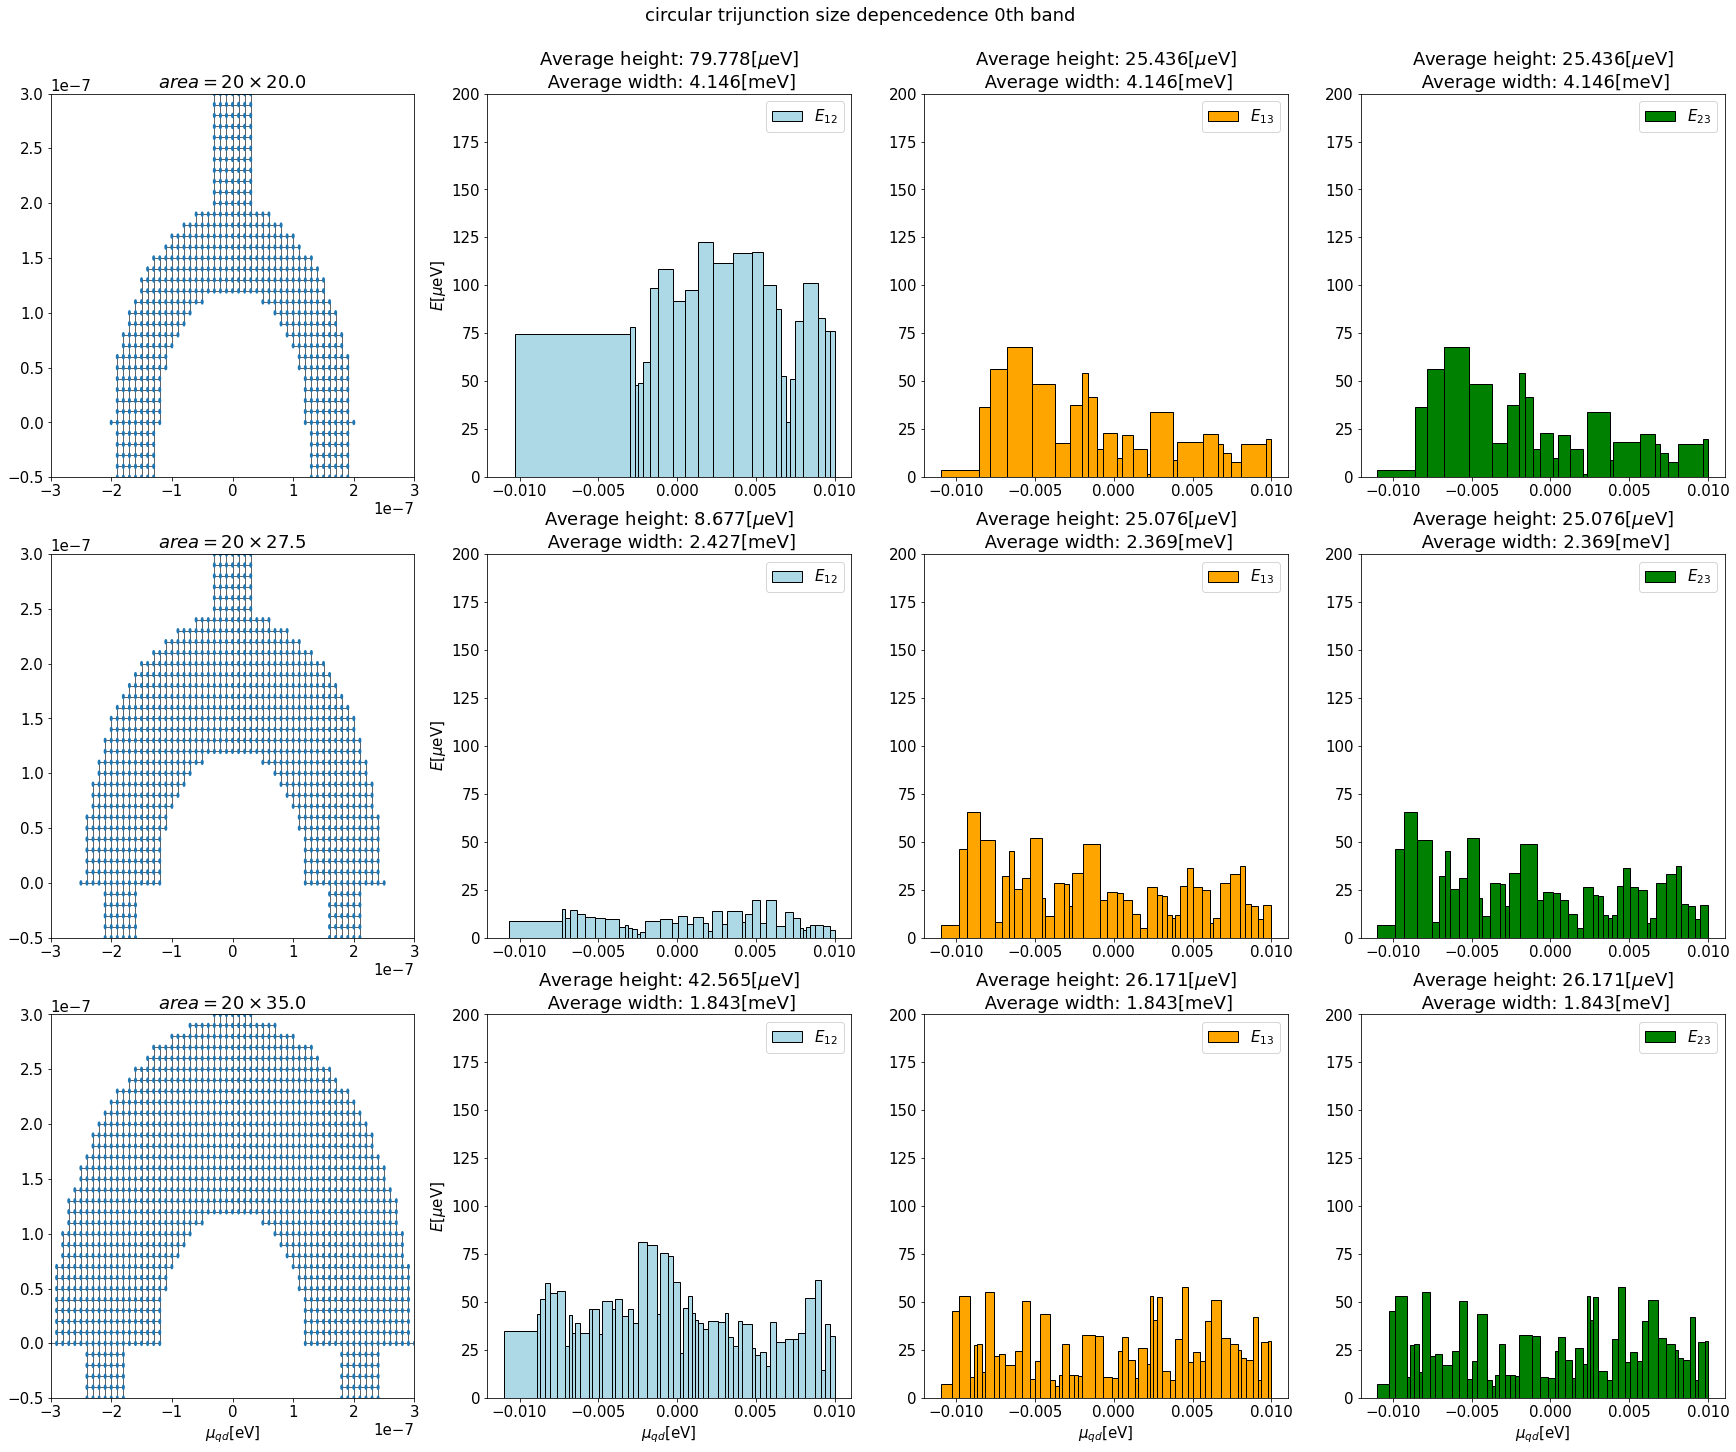

In [77]:
tl.plot_average_couplings(tjs=tjs,
                          average_data=average_data,
                          title=title,
                          n_geometries=n_geometries,
                          subtitles=subtitles,
                          xlims=xlims,
                          ylims=ylims)

## Calculation: all bands

In [37]:
mus_qd = np.linspace(-0.011, 0.01, 200)
key = 'mu_qd'
n = 6
eigen = tl.solver(n=n, key=key)

In [38]:
def wrap(args):
    return eigen(*args)

ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=KeyError("('wrap-979c5e2f4730fae63c80be76d17b0b39', 16)")>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/distributed/client.py", line 1791, in _gather
    await All(
  File "/opt/conda/lib/python3.9/site-packages/distributed/utils.py", line 208, in All
    result = await tasks.next()
  File "/opt/conda/lib/python3.9/site-packages/distributed/client.py", line 1782, in wait
    st = self.futures[k]
KeyError: "('wrap-979c5e2f4730fae63c80be76d17b0b39', 17)"

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/tornado/gen.py", line 769, in run
    yielded = self.gen.throw(*exc_info)  # type: ignore
  File "/opt/conda/lib/python3.9/site-packages/distributed/utils.py", line 221, in quiet
    yield task
  File "/opt/conda/lib/python3.9/site-packages/tornado/gen.py", line 762, 

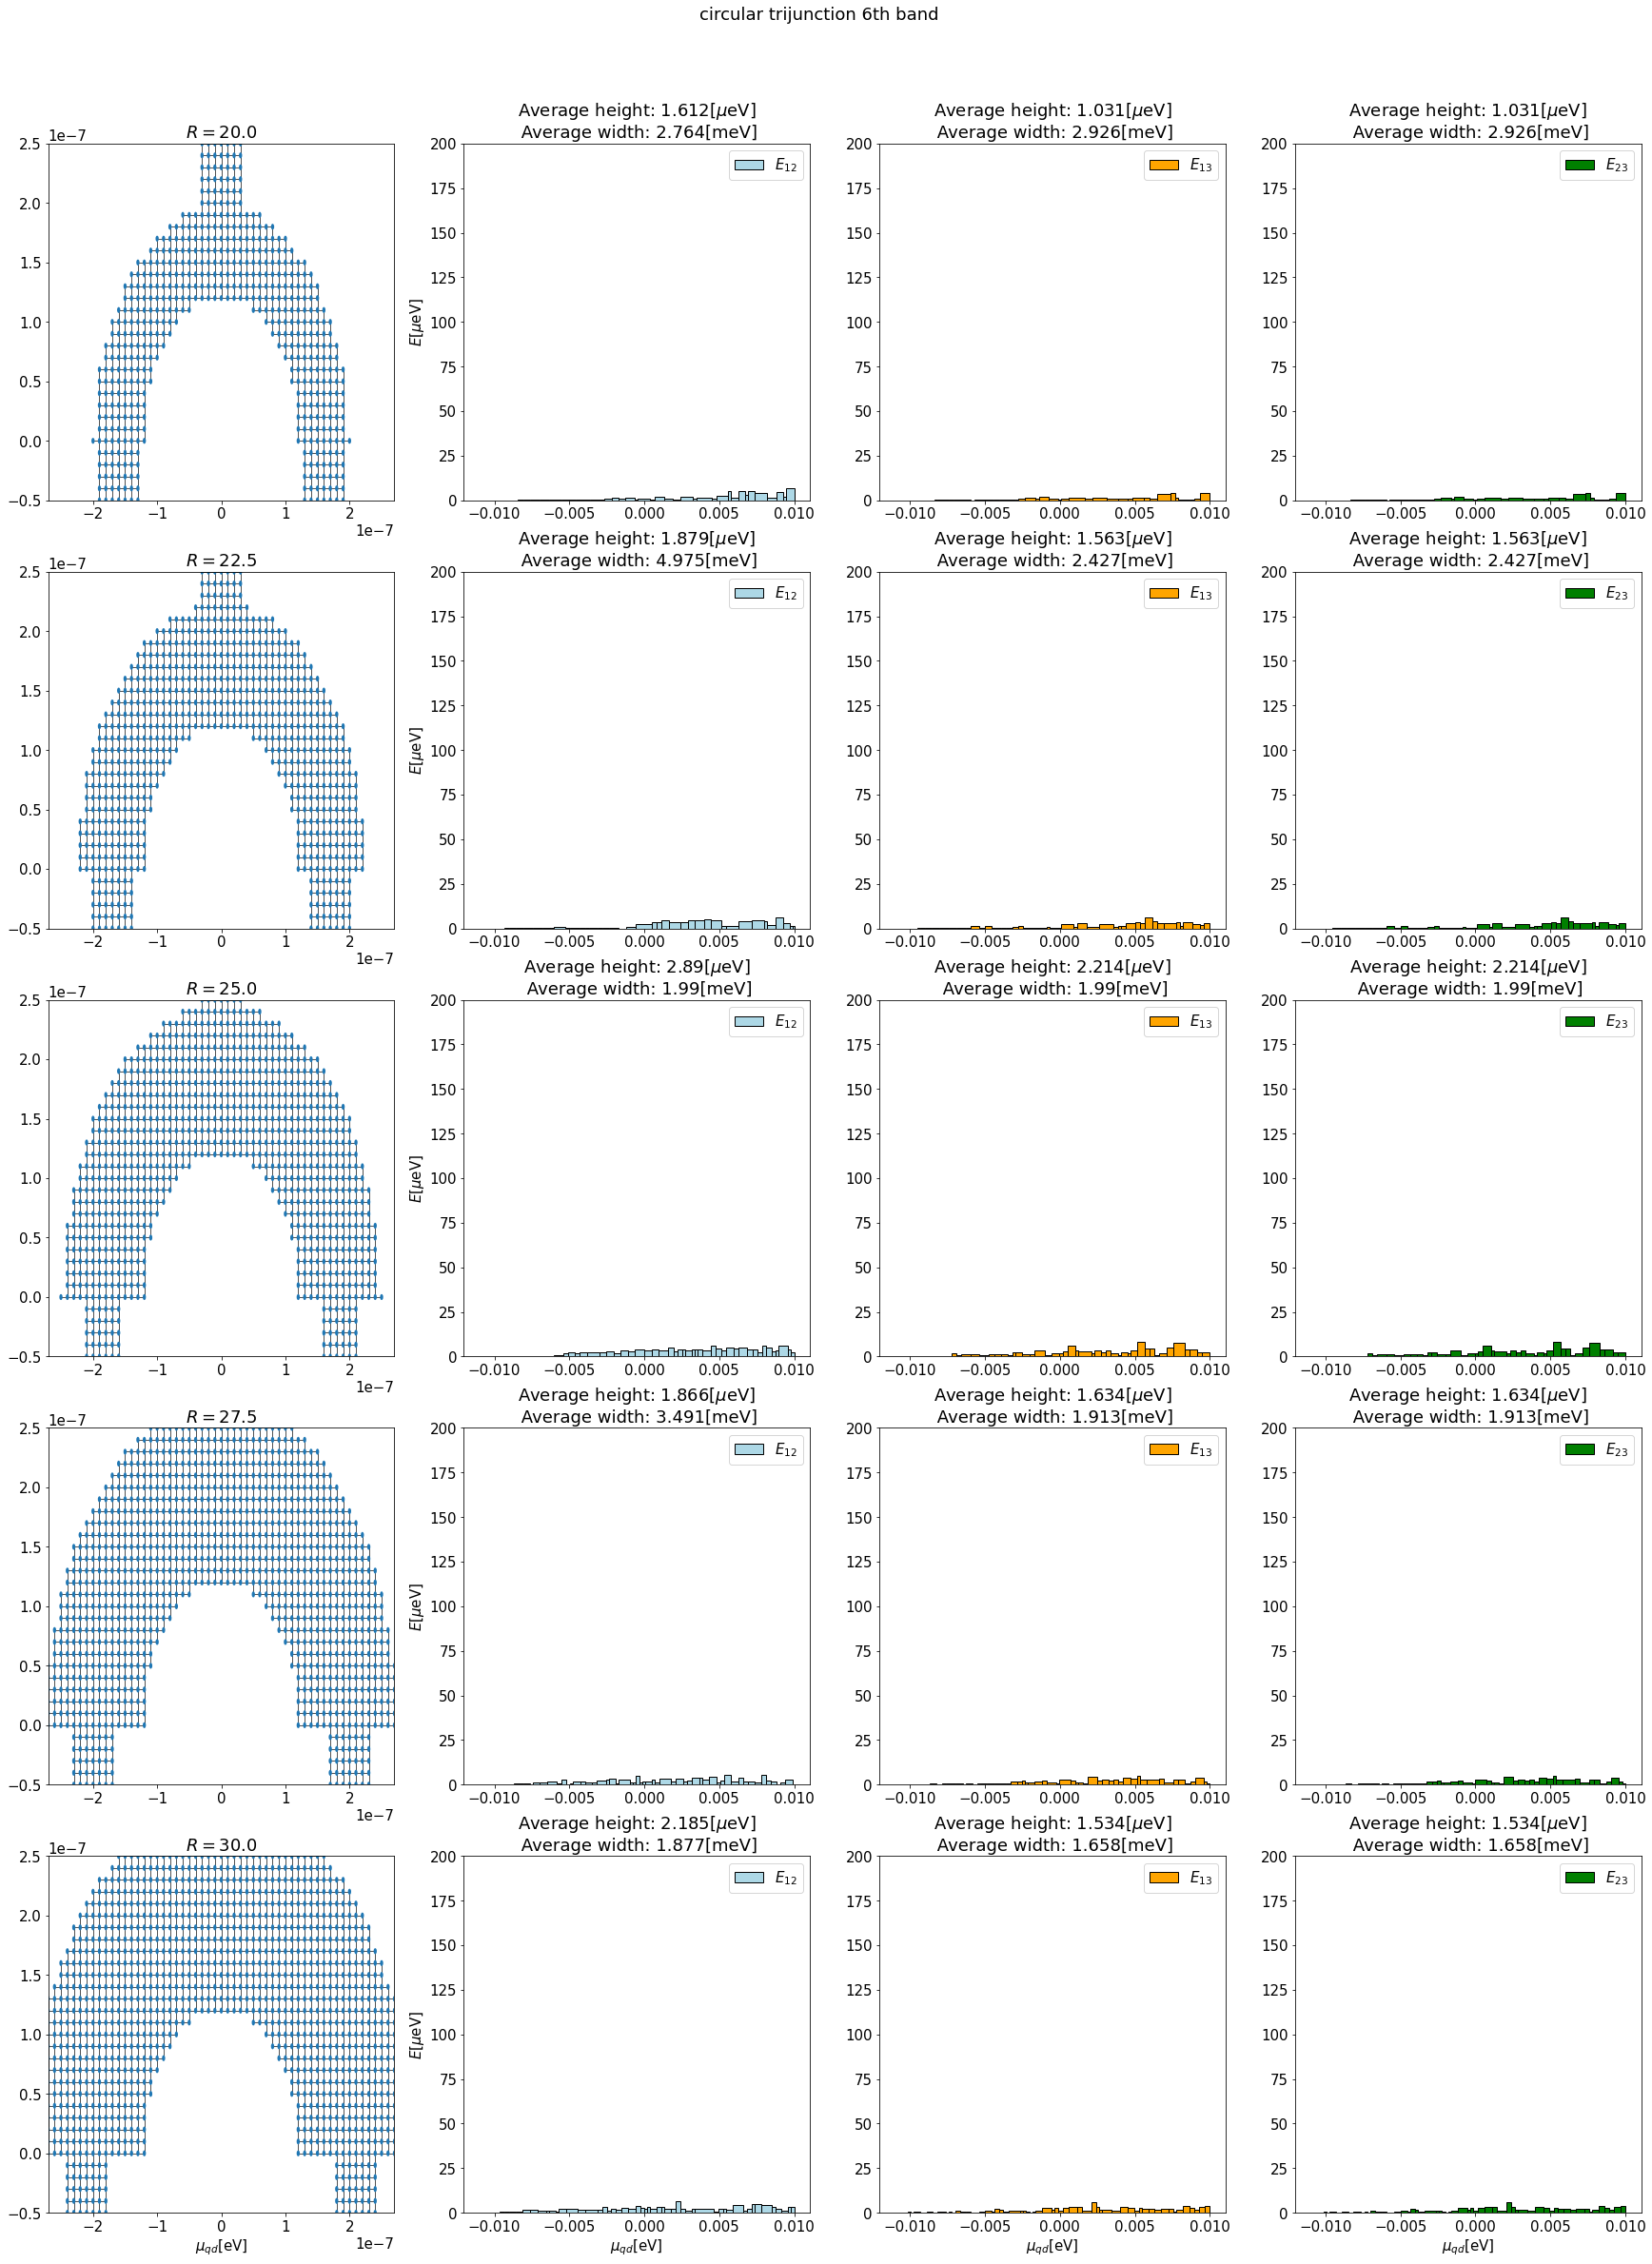

In [41]:
xlims = (-2.7e-7, 2.7e-7)
ylims = (-0.5e-7, 2.5e-7)

subtitles = []
for i in range(n_geometries):
    subtitles.append(r'$R=$'+str(np.round(tj_rads[i]/a, 3)))

for index in range(7):

    params = tl.finite_coupling_parameters(index=index)
    title = 'circular trijunction '+str(index)+'th band'
    
    args = list(it.product(tjs, mus_qd, params))
    args_db = db.from_sequence(args, npartitions=20)
    result = args_db.map(wrap).compute()
    
    average_data = []
    full_data = []
    data_geometries = tl.separate_data_geometries(data=result, n_geometries=n_geometries)

    for geometry in data_geometries:
        average_data.append(tl.average_energy_levels(mus=mus_qd, result=geometry))
        couplings, _, _ = tl.coupling_data(data=geometry, n=n)
        full_data.append(couplings)

    with open('../data/average_'+title.replace(' ', '_')+'.pickle', 'wb') as file:
        pickle.dump(average_data, file)

    with open('../data/full_'+title.replace(' ', '_')+'.pickle', 'wb') as file:
        pickle.dump(full_data, file)

    tl.plot_couplings(tjs=tjs,
                      mus=mus_qd,
                      full_data=full_data,
                      title=title,
                      n_geometries=n_geometries,
                      subtitles=subtitles,
                      xlims=xlims,
                      ylims=ylims,
                      ylim=200)

    tl.plot_average_couplings(tjs=tjs,
                              average_data=average_data,
                              title=title,
                              n_geometries=n_geometries,
                              subtitles=subtitles,
                              xlims=xlims,
                              ylims=ylims,
                              ylim=200)

# Triangular geometry

## Set up

In [11]:
geometry = {
    "l": 70*a,
    "w": 7*a,
    "a": a,
    "side": 'up',
    "shape": 'triangle',
    "A": 400*a**2
}

In [12]:
n_geometries = 8
tj_angles = np.linspace(0.05, 0.4, n_geometries)*np.pi

In [13]:
tjs = []
for theta in tj_angles:
    geometry.update(angle=theta)
    trijunction, f_params, _ = finite_system(**geometry)
    trijunction = trijunction.finalized()
    tjs.append([trijunction, f_params])

/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecati

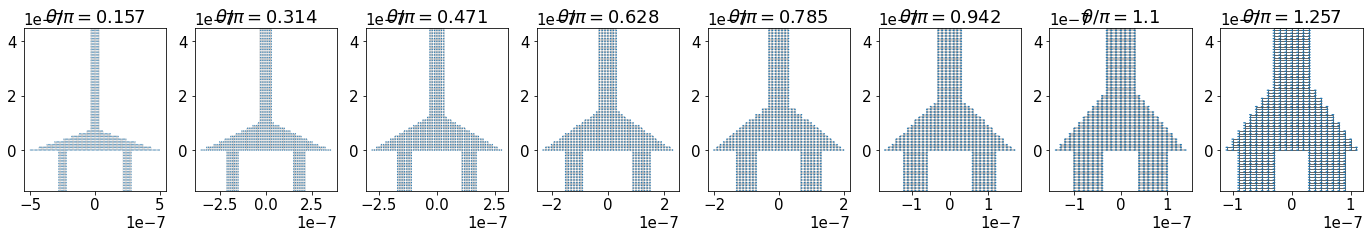

In [14]:
fig, ax = plt.subplots(ncols=n_geometries, nrows=1, figsize=(3*n_geometries, 3))
i = 0
for axes in ax.flatten():
    kwant.plot(tjs[i][0], ax=axes)
    axes.set_ylim(-1.5e-7, 4.5e-7)
    axes.set_title(r'$\theta/\pi=$'+str(np.round(tj_angles[i], 3)))
    #axes.set_xlim(-5e-7, 5e-7)
    #axes.set_title(r'$\theta/\pi$='+str(np.round(angles[i], 3)))
    i += 1

## Calculation: single band

In [17]:
# index is used to choose the sub band of a wire of width 7*a
index = 0
params = tl.finite_coupling_parameters(index=index)
title = 'triangular trijunction angle depencedence '+str(index)+'th band'

In [18]:
mus_qd = np.linspace(-0.011, 0.01, 200)
key = 'mu_qd'
n = 6
eigen = tl.solver(n=n, key=key)

In [19]:
def wrap(args):
    return eigen(*args)

In [20]:
args = list(it.product(tjs, mus_qd, params))
args_db = db.from_sequence(args, npartitions=20)

In [21]:
result = args_db.map(wrap).compute()

In [116]:
path = '../data/trianglex_0th.pickle'
with open(path, 'wb') as file:
    pickle.dump(result, file)

In [58]:
def average_energy_levels(mus, result, normalized=True):
    geometry_data = []
    ens, _, peaks = tl.coupling_data(result, n=6)

    for k in range(3):
        single_average = []
        single_mus = []
        single_widths = []
        single_peaks = np.hstack([0, peaks[k], -1])
        indices_intervals = zip(single_peaks, single_peaks[1:])

        for i, j in indices_intervals:
            energy_section = np.abs(ens[k])[i:j]
            ediff = np.abs(mus[j]-mus[i])
            average = np.sum(energy_section)/np.abs(ediff)
            single_average.append(average)
            single_mus.append(mus[i]+ediff/2)
            single_widths.append(ediff)
        minimal_spacing = min(single_widths)
        geometry_data.append([single_mus, single_average, single_widths, minimal_spacing])

    return np.array(geometry_data)

In [59]:
average_data = []
full_data = []
data_geometries = tl.separate_data_geometries(data=result, n_geometries=n_geometries)
for geometry in data_geometries:
    averages = average_energy_levels(mus=mus_qd, result=geometry)
    average_data.append(averages)
    couplings, _, _ = tl.coupling_data(data=geometry, n=n)
    full_data.append(couplings)

In [75]:
xlims = (-6e-7, 6e-7)
ylims = (-0.5e-7, 3e-7)

subtitles = []
for i in range(n_geometries):
    subtitles.append(r'$angle=$'+str(np.round(tj_angles[i], 3))+r'$\times\pi$')

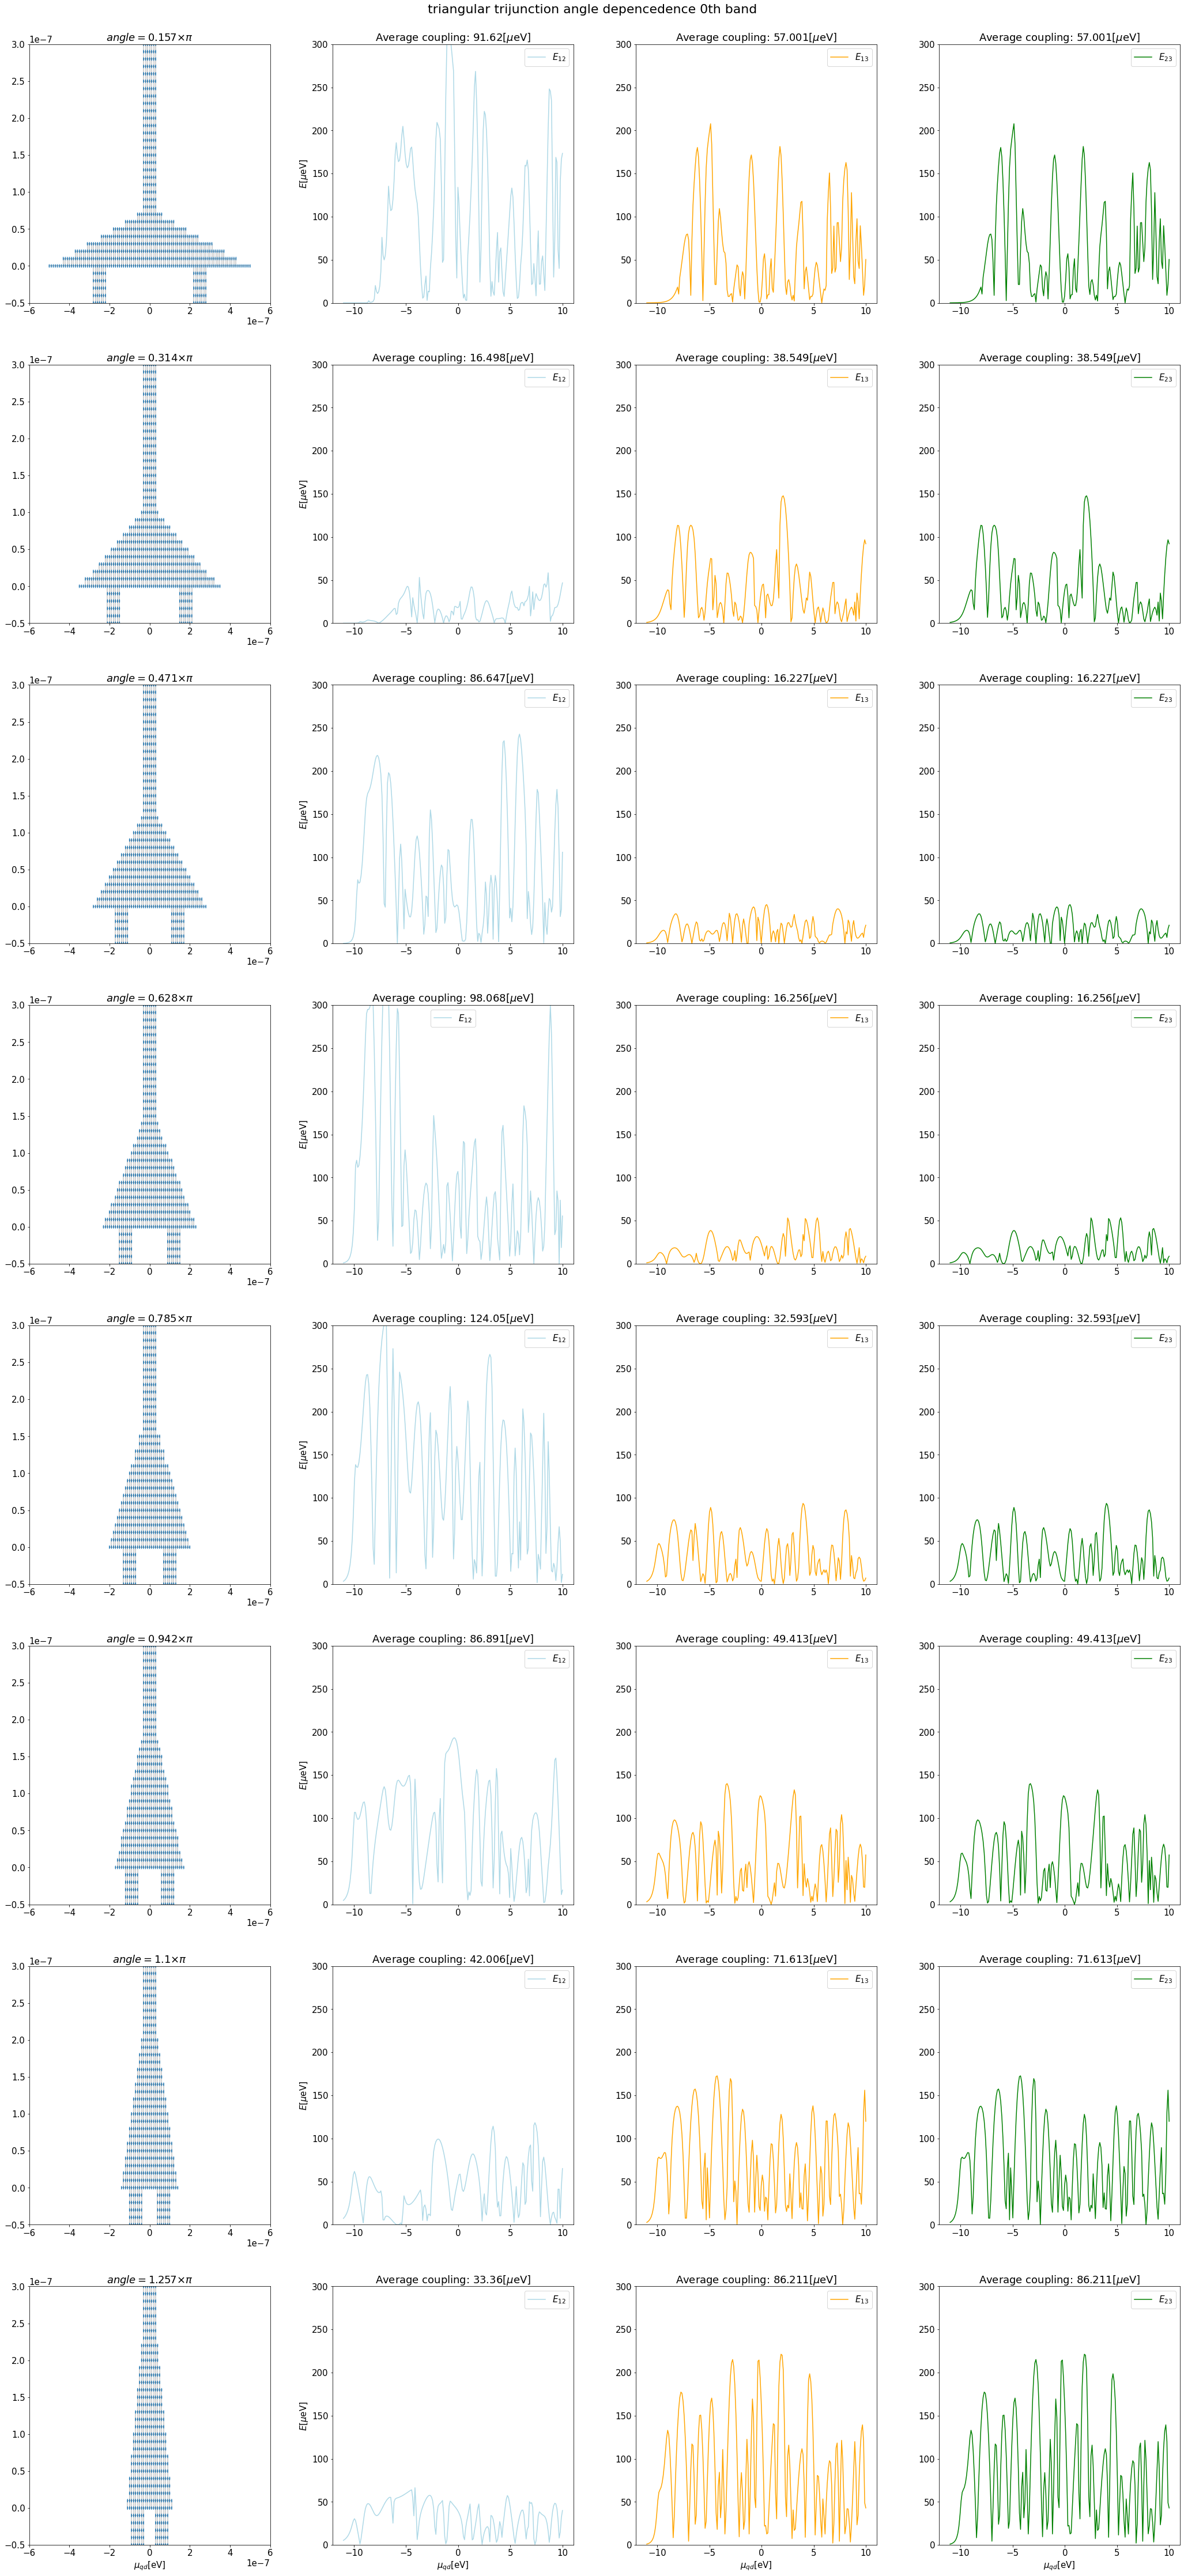

In [115]:
plot_couplings(tjs=tjs,
                  mus=mus_qd,
                  full_data=full_data,
                  title=title,
                  n_geometries=n_geometries,
                  subtitles=subtitles,
                  xlims=xlims,
                  ylims=ylims,
                  ylim=300)

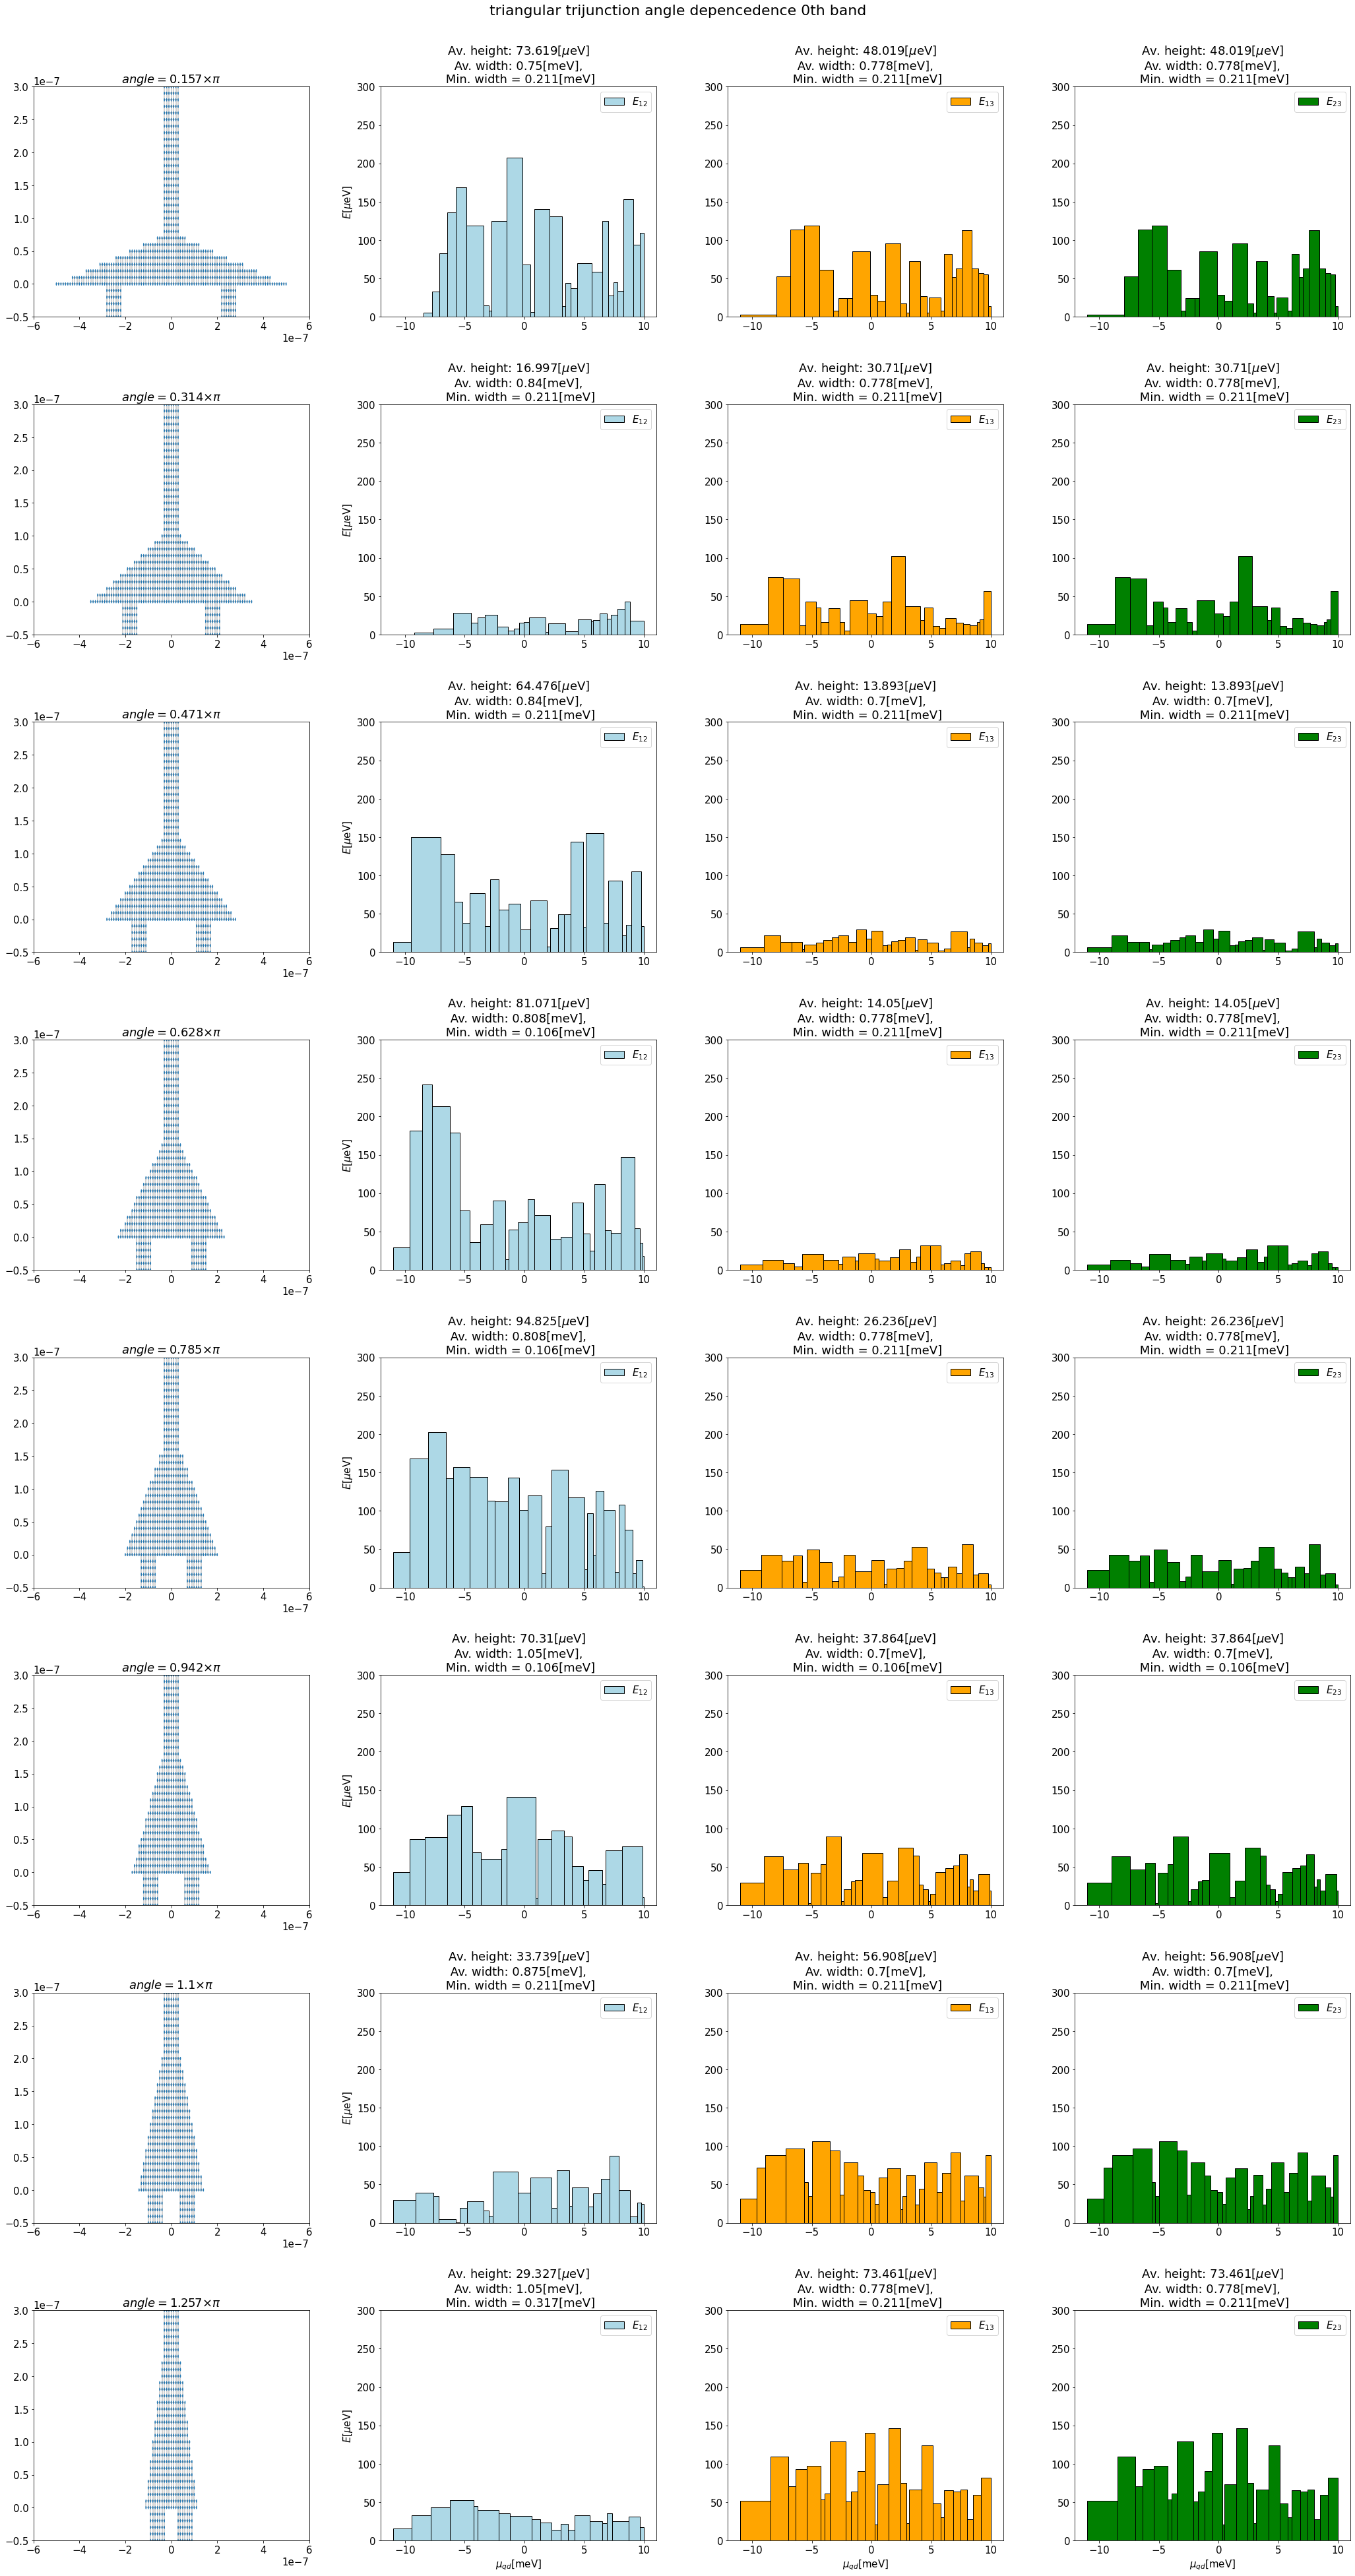

In [111]:
plot_average_couplings(tjs=tjs,
                          average_data=average_data,
                          title=title,
                          n_geometries=n_geometries,
                          subtitles=subtitles,
                          xlims=xlims,
                          ylims=ylims,
                          ylim=300)

## Calculation: all bands

In [17]:
mus_qd = np.linspace(-0.011, 0.01, 200)
key = 'mu_qd'
n = 6
eigen = tl.solver(n=n, key=key)

In [18]:
def wrap(args):
    return eigen(*args)

In [19]:
for index in range(7):

    params = tl.finite_coupling_parameters(index=index)
    
    args = list(it.product(tjs, mus_qd, params))
    args_db = db.from_sequence(args, npartitions=20)
    result = args_db.map(wrap).compute()
    
    path = '../data/angles_triangle_band_'+str(index)+'th.pickle'
    with open(path, 'wb') as file:
        pickle.dump(result, file)